# **Modelling & Evaluation**

## Objectives

* Fit and evaluate a regression model to predict the sale price of inherited houses.

## Inputs

* outputs/datasets/collection/HousePrice.csv
* instructions on which variables to use for data cleaning and feature engineering, found in data cleaning and feature engineering notebooks.

## Outputs

* 

## Additional Comments

* 


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Prediction-heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Prediction-heritage-housing'

---

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/HousePrice.csv"))

print(df.shape)
df.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

# MP Pipeline: Regressor

## Create ML pipeline

In [5]:
from sklearn.pipeline import Pipeline

# Data Cleaning &cFeature Engineering
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import DropFeatures, SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([
        # Pipeline taken from the DataCleaning notebook
        ( 'drop',  DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF']) ),
        
        ( 'categorical',  CategoricalImputer(imputation_method='missing',
                                     fill_value='Missing',
                                     variables=['GarageFinish', 'BsmtFinType1']) ),
        ( 'mean',  MeanMedianImputer(imputation_method='mean',
                                     variables=['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']) ),

        #Pipeline taken from the conclusions of FeatureEngineering notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        
        ('log_transform', vt.LogTransformer(variables = ['1stFlrSF', 'GrLivArea', 'LotFrontage']) ),

        ('yeo_johnson_transform', vt.YeoJohnsonTransformer(variables=['TotalBsmtSF'])),

        ('box_cox_transform', vt.BoxCoxTransformer(variables = ['LotArea'])),

        ('power_transform', vt.PowerTransformer(variables = ['GarageArea', 'MasVnrArea']) ),

        ("Winsoriser_iqr",Winsorizer(capping_method='iqr', fold=1.5, tail='both', 
                                                  variables=['1stFlrSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'MasVnrArea', 'OpenPorchSF']) ),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for hyperparameter optimisation:

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train Test Set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Then do a hyperparameter optimization search using default hyperparameters:

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/select


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/select


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/select


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/select


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/select


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/select


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be remove

Check results of the hyperparameter optimization search:

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.718572,0.789443,0.843543,0.045437
3,ExtraTreesRegressor,0.711786,0.778273,0.826432,0.051667
0,LinearRegression,0.70851,0.747556,0.816245,0.038598
2,RandomForestRegressor,0.583409,0.744344,0.825657,0.083256
4,AdaBoostRegressor,0.621034,0.699678,0.788404,0.056549
6,XGBRegressor,0.609809,0.664265,0.702111,0.034727
1,DecisionTreeRegressor,0.426996,0.583387,0.71915,0.117071


The average R2 score is around 0.79, which is higher than the 0.75 we decided in the business case. 

## Extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search:

In [11]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor":{'model__n_estimators': [50,100,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },
}

Extensive GridSearch CV:

In [12]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/select

Check results of GridSearch CV:

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
15,GradientBoostingRegressor,0.755327,0.797358,0.842103,0.035133,3,1,50,50
16,GradientBoostingRegressor,0.756432,0.796414,0.845261,0.031243,3,1,50,100
17,GradientBoostingRegressor,0.746903,0.792425,0.841942,0.03462,3,1,50,150
27,GradientBoostingRegressor,0.754365,0.790117,0.815819,0.028249,15,1,50,50
13,GradientBoostingRegressor,0.718572,0.789443,0.843543,0.045437,3,1,2,100
14,GradientBoostingRegressor,0.717128,0.789305,0.840938,0.044453,3,1,2,150
12,GradientBoostingRegressor,0.715384,0.787421,0.841932,0.049564,3,1,2,50
3,GradientBoostingRegressor,0.737177,0.785743,0.818061,0.02884,None,1,50,50
20,GradientBoostingRegressor,0.701735,0.78432,0.830667,0.04867,3,50,2,150
23,GradientBoostingRegressor,0.701735,0.78432,0.830667,0.04867,3,50,50,150


The average R2 score improved slightly and is now around 0.8. So the performance increased slightly after the extensive search.

We check the best model:

In [14]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

Parameters for best model:

In [15]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 3,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 50}

Define the best regressor, based on search:

In [16]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('drop',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('categorical',
                 CategoricalImputer(variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'BedroomAbvGr',
                                              '2ndFlrSF', 'GarageYrBlt',
                                              'MasVnrArea'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',

## Assess feature importance

* These are the 5 most important features in descending order. The model was trained on them: 
['YearBuilt', 'TotalBsmtSF', 'GarageArea', '2ndFlrSF', 'LotArea']


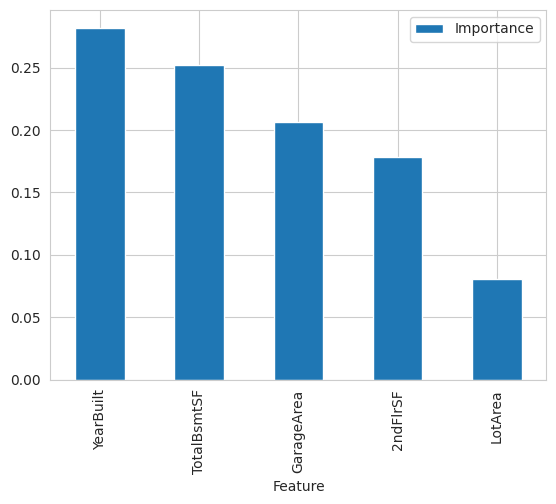

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# The pipeline has 10 steps of data cleaning and feature engineering
data_cleaning_feat_eng_steps = 10
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps]).transform(X_train).columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Evaluate on Train and Test Sets

We are checking how this pipeline performs:

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.savefig(f'docs/plots/regression_performance.png', bbox_inches='tight')

Evaluate Performance:

Model Evaluation 

* Train Set
R2 Score: 0.873
Mean Absolute Error: 19638.676
Mean Squared Error: 784664429.938
Root Mean Squared Error: 28011.862


* Test Set
R2 Score: 0.747
Mean Absolute Error: 25841.971
Mean Squared Error: 1750060953.144
Root Mean Squared Error: 41833.73




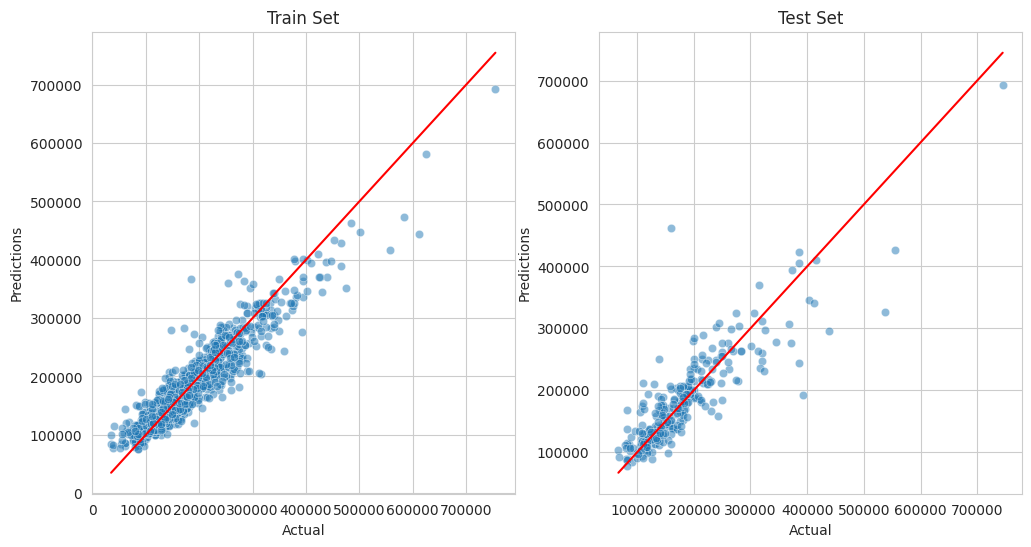

In [19]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

* We can see that the test set is slightly under the R2 score of 0.75 and the train set is well above. If we round the scores, we can say that the regressor pipeline reached the expected performance threshold.
* We also note in the plots that Prediction x Actual plot, the predictions tend to follow the actual value (since it kind of follows the red diagonal line).

----

## Pipeline

The regressor pipeline reached the expected performance threshold (0.75 R2 score): 
* around 0.87 for the Train set,
* around 0.75 for the Test set.

In [20]:
best_regressor_pipeline

Pipeline(steps=[('drop',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('categorical',
                 CategoricalImputer(variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'BedroomAbvGr',
                                              '2ndFlrSF', 'GarageYrBlt',
                                              'MasVnrArea'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',

---

## Refit pipeline with best features

### Rewrite Pipeline

In [21]:
# Reminder the most important features are: ['YearBuilt', 'TotalBsmtSF', 'GarageArea', '2ndFlrSF', 'LotArea']

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        # Data Cleaning for only the most important features
        
        ( 'mean',  MeanMedianImputer(imputation_method='mean',
                                     variables=['2ndFlrSF']) ),

        ## Feature Engineering for only the most important features

        ('yeo_johnson_transform', vt.YeoJohnsonTransformer(variables=['TotalBsmtSF'])),

        ('box_cox_transform', vt.BoxCoxTransformer(variables = ['LotArea'])),

        ('power_transform', vt.PowerTransformer(variables = ['GarageArea']) ),

        ("Winsoriser_iqr",Winsorizer(capping_method='iqr', fold=1.5, tail='both', 
                                                  variables=['TotalBsmtSF', 'GarageArea']) ),

        ("feat_scaling", StandardScaler()),

        # feature selection is not needed

        ("model", model),

    ])

    return pipeline_base


### Split Train Test Set, only with best features

In [22]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 5) (1168,) 
* Test set: (292, 5) (292,)


,2ndFlrSF,GarageArea,LotArea,TotalBsmtSF,YearBuilt
618,0.0,774,11694,1822,2007
870,0.0,308,6600,894,1962
92,0.0,432,13360,876,1921


### Grid Search CV – Sklearn

We are using the same model from the previous GridCV search:

In [23]:
models_search

{'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0)}

And the best parameters from the previous GridCV search:

In [24]:
best_parameters

{'model__max_depth': 3,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 50}

Type in manually since the hyperparameter values have to be a list:

In [25]:
params_search = {
    "GradientBoostingRegressor": {
        'model__max_depth': [3],
        'model__min_samples_leaf': [1],
        'model__min_samples_split': [50],
        'model__n_estimators': [50]
        }
}
params_search

{'GradientBoostingRegressor': {'model__max_depth': [3],
  'model__min_samples_leaf': [1],
  'model__min_samples_split': [50],
  'model__n_estimators': [50]}}

### GridSearch CV

In [26]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results:

In [27]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,GradientBoostingRegressor,0.691014,0.766173,0.842103,0.050037,3,1,50,50


Check the best model:

In [28]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Define the best pipeline:

In [29]:
best_pipeline_regressor = grid_search_pipelines[best_model].best_estimator_
best_pipeline_regressor

Pipeline(steps=[('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['2ndFlrSF'])),
                ('yeo_johnson_transform',
                 YeoJohnsonTransformer(variables=['TotalBsmtSF'])),
                ('box_cox_transform', BoxCoxTransformer(variables=['LotArea'])),
                ('power_transform', PowerTransformer(variables=['GarageArea'])),
                ('Winsoriser_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['TotalBsmtSF', 'GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(min_samples_split=50,
                                           n_estimators=50, random_state=0))])

## Assess feature importance

We are saving the 5 most important features plot that we found:

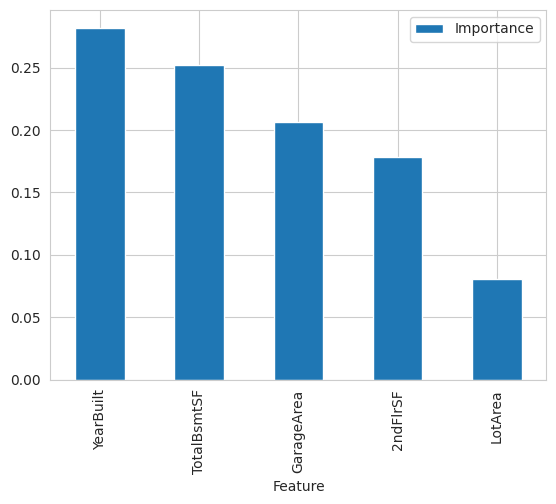

In [30]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

---

# Push files to Repo

We will generate the following files:
* Train set
* Test set
* Modeling pipeline
* Label map
* Features importance plot

In [31]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_price/{version}' # create file

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_price/v1'


### Train Set: features and target

In [32]:
X_train.head()

,2ndFlrSF,GarageArea,LotArea,TotalBsmtSF,YearBuilt
618,0.0,774,11694,1822,2007
870,0.0,308,6600,894,1962
92,0.0,432,13360,876,1921
817,0.0,857,13265,1568,2002
302,0.0,843,13704,1541,2001


In [33]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [34]:
y_train.head()

618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [35]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set: features and target

In [36]:
X_test.head()

,2ndFlrSF,GarageArea,LotArea,TotalBsmtSF,YearBuilt
529,0.0,484,32668,2035,1957
491,620.0,240,9490,806,1941
459,224.0,352,7015,709,1950
279,866.0,505,10005,1160,1977
655,NaN,264,1680,525,1971


In [37]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [38]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [39]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### Modelling pipeline

ML pipeline for predicting Sale Price:

In [40]:
best_pipeline_regressor

Pipeline(steps=[('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['2ndFlrSF'])),
                ('yeo_johnson_transform',
                 YeoJohnsonTransformer(variables=['TotalBsmtSF'])),
                ('box_cox_transform', BoxCoxTransformer(variables=['LotArea'])),
                ('power_transform', PowerTransformer(variables=['GarageArea'])),
                ('Winsoriser_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['TotalBsmtSF', 'GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(min_samples_split=50,
                                           n_estimators=50, random_state=0))])

In [41]:
joblib.dump(value=best_pipeline_regressor, filename=f"{file_path}/regression_pipeline.pkl")

['outputs/ml_pipeline/predict_price/v1/regression_pipeline.pkl']

### Feature importance plot

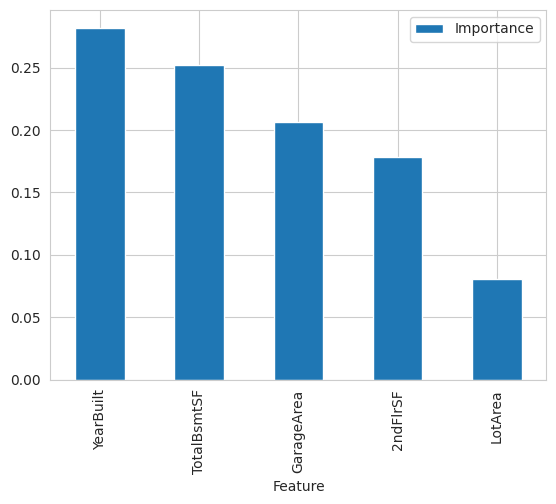

In [42]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'docs/plots/best_features.png', bbox_inches='tight') 

---

## Conclusions

The feature performance plot shows that variables related to the year the property was built, the size but also the existance of a Garage and the size of the lot have high predictive power.

['YearBuilt', 'TotalBsmtSF', 'GarageArea', '2ndFlrSF', 'LotArea']

As we hypothesized:
* The year to the year the property was built : ['YearBuilt']
* The size of impact the price of the house : ['TotalBsmtSF', 'GarageArea', '2ndFlrSF']
* Another feature impact the price : ['LotArea']

However, we saw that the quality wasn't included.